In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors,cm
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scalebar import scale_bar

Plot consecitive displacement between a pair of particles.

Sample simulations of DVM II and 2D particles from June 2017

In [2]:
home_folder = "/nethome/manra003/analysis/dispersion/"
min_lat, max_lat = -35, -15
min_lon, max_lon = 10, 20
type1, type2 = "DVM", "2D"
dvm_label = "DVM II"
year = 2017
month_index = 5
threshold_dist = 100
t_days = 100

dist = np.load(home_folder + "outputs/Distances/{0}-{1}/all_sep_array_{0}_{1}_{2}_tc{3}km.npy".format(
    type1, type2, year, threshold_dist))
ds1 = xr.open_zarr(home_folder+'simulations/{0}/{1}/Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.zarr'.format(
    type1, year, str(month_index+1).zfill(2)))
ds2 = xr.open_zarr(home_folder+'simulations/{0}/{1}/Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.zarr'.format(
    type2, year, str(month_index+1).zfill(2)))

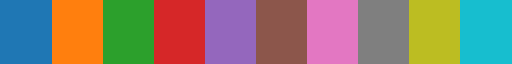

In [3]:
dpi = 100
cmap = plt.get_cmap('tab10')
new_cmap = colors.ListedColormap(cmap(np.arange(10)))
colors2 = [new_cmap(3), new_cmap(2), new_cmap(4)]

markers2 = ['^', 'P', 'd']
new_cmap

In [4]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,:,:,:]

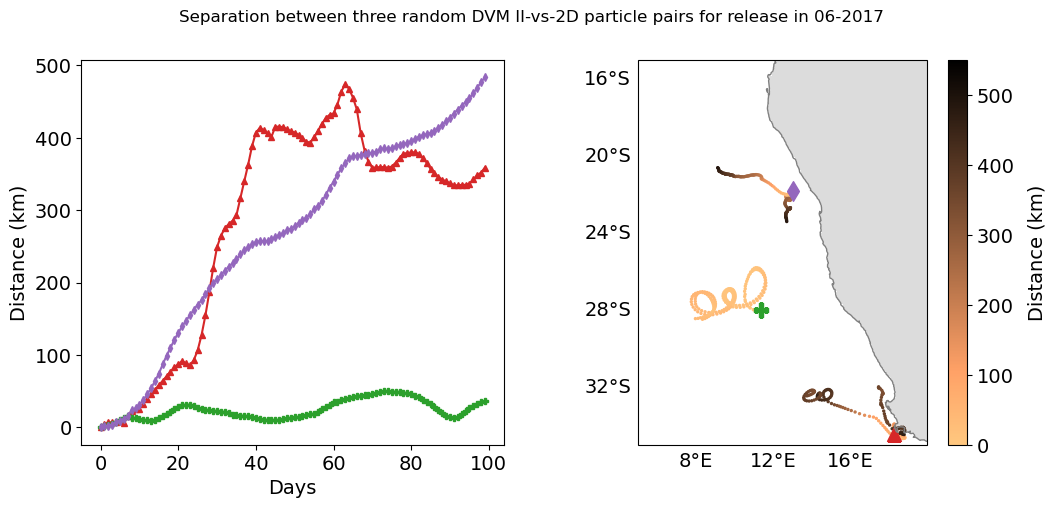

In [5]:
positions = [5574, 56234, 86902]
markers = ['+', 'd', 'x']

custom_size, ticks_size = 14, 14

fig = plt.figure(figsize=(12, 5), dpi=dpi)
fig.suptitle("Separation between three random {0}-vs-{1} particle pairs for release in {2}-{3}".format(
    dvm_label, type2, str(month_index+1).zfill(2), year))

ax1 = fig.add_subplot(1, 2, 1)
for index, p in enumerate(positions):
    ax1.plot(dist[p, :, month_index], label=p, markersize=4, linewidth=None,
             color=colors2[index], marker=markers2[index])
ax1.tick_params("both", labelsize=custom_size)

ax1.set_ylabel("Distance (km)", fontsize=custom_size)
ax1.set_xlabel("Days", fontsize=custom_size)

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
colormap = colors.ListedColormap(['gainsboro', 'white'])
gl = ax2.gridlines(draw_labels=True)
x_ticks = np.arange(0, 20, 4)
y_ticks = np.arange(-36, -14, 4)
gl.xlines = False
gl.xlocator = mticker.FixedLocator(x_ticks)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = False
gl.ylocator = mticker.FixedLocator(y_ticks)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': ticks_size, 'color': 'k'}
gl.ylabel_style = {'size': ticks_size, 'color': 'k'}
ax2.tick_params("both", labelsize=custom_size)
ax2.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax2.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750,
               1499:], mask_land[0, 0, 1250:1750, 1500:], cmap=colormap)

for index, p in enumerate(positions):
    distance = dist[p, :, month_index]
    im = ax2.scatter(ds1.lon[p, :100], ds1.lat[p, :100],
                     c=distance, cmap='copper_r', vmin=0, vmax=550, s=2)
    ax2.scatter(ds2.lon[p, :100], ds2.lat[p, :100],
                c=distance, cmap='copper_r', vmin=0, vmax=550, s=2)
    ax2.scatter(ds1.lon[p, 0], ds1.lat[p, 0], marker=markers2[index],
                s=100, color=colors2[index])

ax2.set_xlim(5, max_lon)
ax2.set_ylim(min_lat, max_lat)

cbar = fig.colorbar(im, ax=ax2, orientation='vertical')
cbar.set_label(label='Distance (km)', size=custom_size, labelpad=10)
cbar.ax.tick_params(labelsize=custom_size)

plt.savefig(home_folder + "outputs/Figures/" +
            "Eg_DVMII-2D_Pair_separations_{0}-2017.jpeg".format(str(month_index+1).zfill(2)))


Select one month and see how separation varies for a month for a selected particle pair:

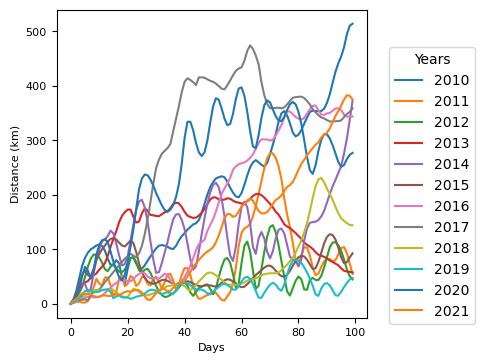

In [6]:
position = positions[0]
custom_size = 8
fig = plt.figure(figsize=(4, 4), dpi=dpi)
ax = plt.axes()
for y in range(2010, 2022):
    dist_temp = np.load(
        home_folder + "outputs/Distances/{0}-{1}/all_sep_array_{0}_{1}_{2}_tc{3}km.npy".format(type1, type2, y, threshold_dist))
    ax.plot(dist_temp[positions[0], :, month_index], label=y)
ax.set_ylabel("Distance (km)", fontsize=custom_size)
ax.set_xlabel("Days", fontsize=custom_size)
ax.tick_params(axis='both', labelsize=custom_size)

plt.legend(bbox_to_anchor=(1.05, 0.9), title='Years')

plt.savefig(home_folder + "outputs/Figures/" +
            "Eg_DVMII-2D_Pair_separations_{0}_allYears_id_{1}.jpeg".format(str(month_index+1).zfill(2), positions[0]))

In [4]:
# function to compute the PDF of distances provided in the array- using bins upto 8000 km 
distance_bins=np.arange(0,8001,25)
bin_centers= (distance_bins[:-1] + distance_bins[1:]) / 2
def compute_distance_pdf(array):
    count, _ = np.histogram(array, bins=distance_bins, range=(0,10000))  
    pdf = count/np.sum(count)  # computation discards particles that were deleted before crossing the threshold distance. very minor
    # cdf = np.cumsum(pdf)
    return pdf


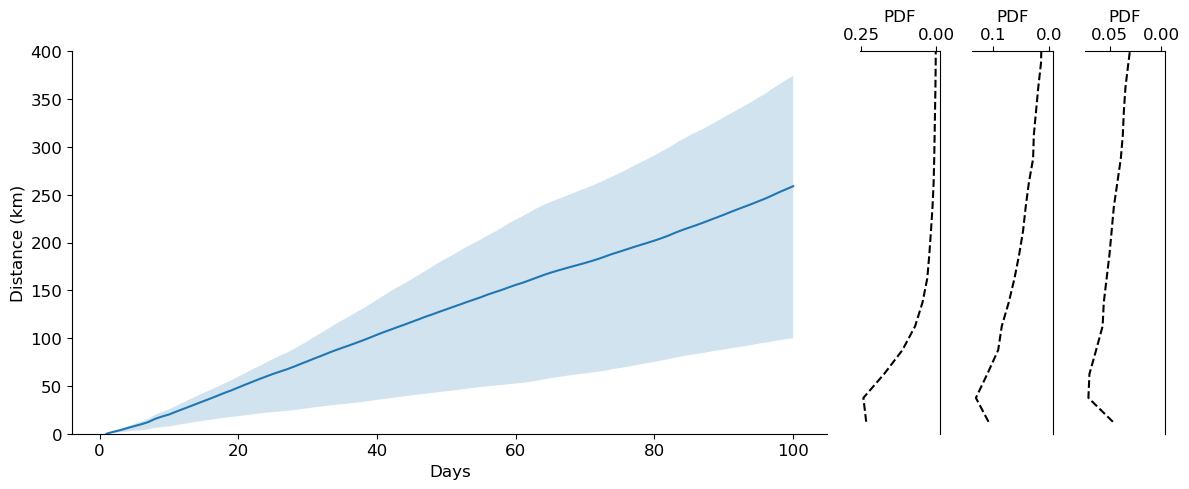

In [8]:
fig = plt.figure(figsize=(12, 5), dpi=dpi)

gs = gridspec.GridSpec(1, 10, figure=fig)

custom_size = 12

y = 2017
days_index = [99, 59, 29]

dist_temp = np.load(
    home_folder + "outputs/Distances/{0}-{1}/all_sep_array_{0}_{1}_{2}_tc{3}km.npy".format(type1, type2, y, threshold_dist))
mean = np.nanmean(dist_temp[:, :, month_index], axis=0)
# std = np.nanstd(dist_temp[:, :, month_index], axis=0)
q3, q1 = np.nanpercentile(dist_temp[:, :, month_index], [75 ,25], axis=0)

sigma = 1

ax1 = fig.add_subplot(gs[0, :7])
ax1.plot(np.arange(1, 101), mean, label=y)
# ax1.fill_between(np.arange(1, 101), mean - sigma *
#                  std, mean + sigma*std, alpha=0.2)
ax1.fill_between(np.arange(1, 101), q1, q3, alpha=0.2)
ax1.set_ylabel("Distance (km)", fontsize=custom_size)
ax1.set_xlabel("Days", fontsize=custom_size)
ax1.set_ylim(0, 400)
ax1.spines[['right', 'top']].set_visible(False)
ax1.tick_params("both", labelsize=custom_size)

for index in range(1, 4):
    pdf_t = compute_distance_pdf(
        dist_temp[:, days_index[index-1], month_index])

    ax_n = fig.add_subplot(gs[0, 10-index], sharey=ax1)
    ax_n.plot(pdf_t, bin_centers, c='k', linestyle='--')
    ax_n.set_xlabel("PDF", fontsize=custom_size)
    ax_n.invert_xaxis()
    ax_n.xaxis.tick_top()
    ax_n.yaxis.tick_right()
    ax_n.xaxis.set_label_position('top')
    ax_n.spines[['left', 'bottom']].set_visible(False)
    ax_n.tick_params("both", labelsize=custom_size)
    ax_n.yaxis.set_visible(False)


fig.tight_layout()  # Adjust layout to make room for the second x-axis
plt.savefig(home_folder + "outputs/Figures/" +
            "Eg_DVMII-2D_PDF_all_separation_distance_{0}-2017.png".format(str(month_index+1).zfill(2)))

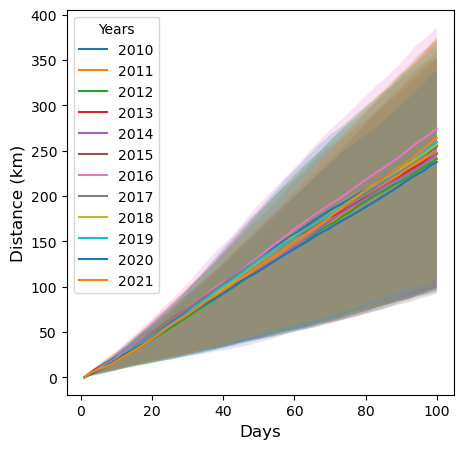

In [9]:
fig = plt.figure(figsize=(5, 5), dpi=dpi)
ax = plt.axes()
for y in range(2010, 2022):
    dist_temp = np.load(
        home_folder + "outputs/Distances/{0}-{1}/all_sep_array_{0}_{1}_{2}_tc{3}km.npy".format(type1, type2, y, threshold_dist))
    mean = np.nanmean(dist_temp[:, :, month_index], axis=0)
    # std = np.nanstd(dist_temp[:, :, month_index], axis=0)
    q3, q1 = np.nanpercentile(dist_temp[:, :, month_index], [75 ,25], axis=0)
    # sigma = 1
    ax.plot(np.arange(1, 101), mean, label=y)
    # ax.fill_between(np.arange(1, 101), mean - sigma *
    #                 std, mean + sigma*std, alpha=0.2)
    ax.fill_between(np.arange(1, 101), q1, q3, alpha=0.2)

ax.set_ylabel("Distance (km)", fontsize=custom_size)
ax.set_xlabel("Days", fontsize=custom_size)
plt.legend(title='Years')

plt.savefig(home_folder + "outputs/Figures/" +
            "Eg_DVMII-2D_Pair_separations_{0}_allYears_Mean.jpeg".format(str(month_index+1).zfill(2)))

Final separation distance after 100 days for a given simulation:

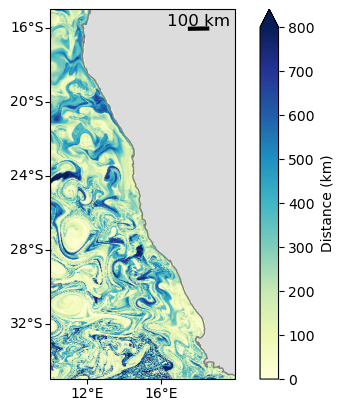

In [10]:
scatter_size = 0.8
days_index=99
input_array = dist[:,-1,month_index]
pre_text='{0}-{1} separation distance on day {2} after release {3}-{4}'.format(dvm_label, type2, days_index+1,str(month_index+1).zfill(2),year)

custom_size=10
ticks_size=10
# fig = plt.figure(figsize=(6,8), dpi=dpi)
fig.suptitle(pre_text)
ax = plt.axes(projection=ccrs.PlateCarree())
x_ticks=np.arange(12,20,4)
y_ticks=np.arange(-36,-14,4)
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.xlocator = mticker.FixedLocator(x_ticks)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = False
gl.ylocator = mticker.FixedLocator(y_ticks)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': ticks_size, 'color': 'k'}
gl.ylabel_style = {'size': ticks_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.tick_params(axis='both',labelbottom=False, labeltop=False, labelleft=False, labelright=False, labelsize=custom_size)
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')

scatter=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= input_array, s=scatter_size, cmap=cm.YlGnBu, marker='o', edgecolors='none',vmin=0.0, vmax=800)
cbar=fig.colorbar(scatter, ax=ax, extend='max')
cbar.set_label(label='Distance (km)', size=custom_size)
cbar.ax.tick_params(labelsize=custom_size)

# for index, p in enumerate(positions):   
#     ax.scatter(ds1.lon[p,0],ds1.lat[p,0],s=100, color=colors2[index], marker=markers2[index])
# scale_bar(ax, 100, location=(0.8, 0.95))

scale_bar(ax, 100, location=(0.8, 0.95))

plt.savefig(home_folder + "outputs/Figures/" + "Eg_DVMII-2D_Final_separation_distance_{0}-2017.jpeg".format(str(month_index+1).zfill(2)))

Plot the separation distance between DVM II-vs-2D particles for June 2017 at different days of the simulations.

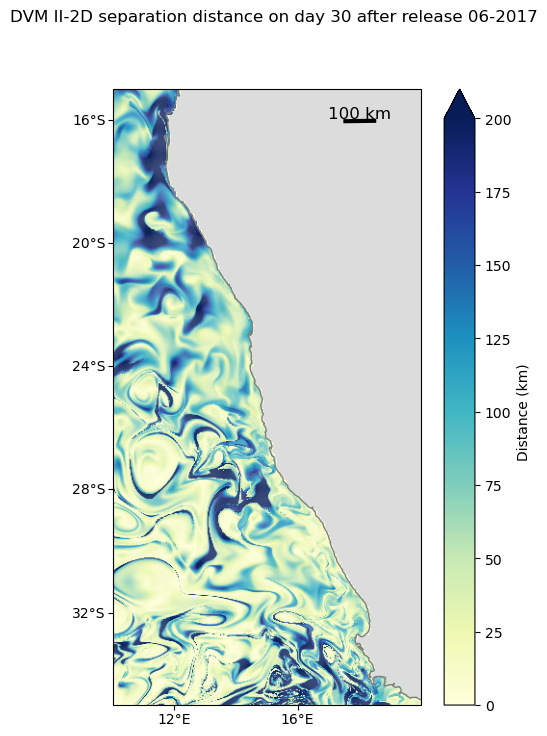

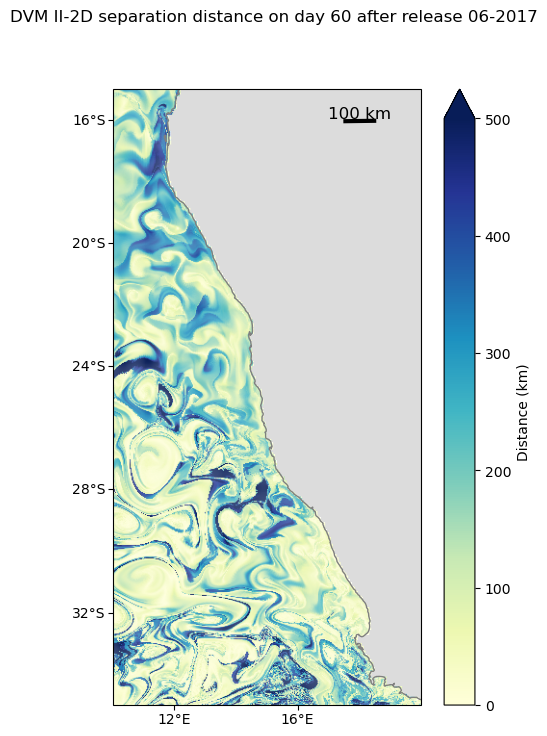

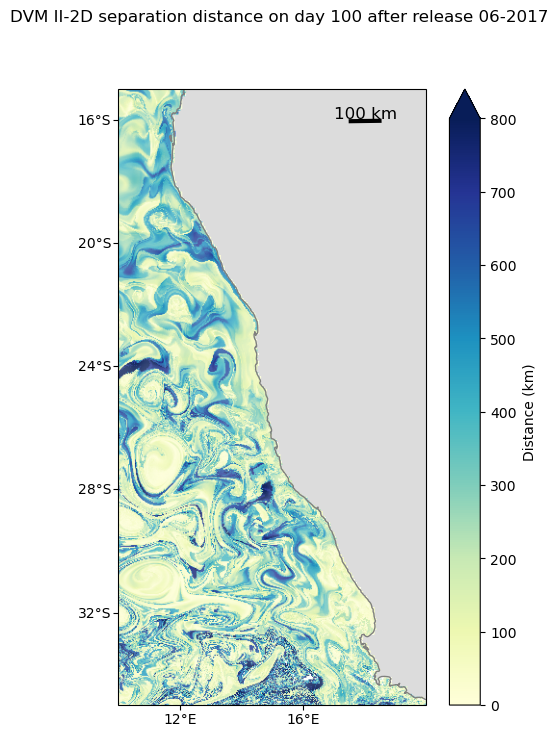

In [11]:
scatter_size = 0.8

custom_size = 10
ticks_size = 10

x_ticks = np.arange(12, 20, 4)
y_ticks = np.arange(-36, -14, 4)

for days_index in (29, 59, 99):

    if days_index == 29:
        max_value = 200
    elif days_index == 59:
        max_value = 500
    elif days_index == 99:
        max_value = 800

    input_array = dist[:, days_index, month_index]
    pre_text = '{0}-{1} separation distance on day {2} after release {3}-{4}'.format(
        dvm_label, type2, days_index+1, str(month_index+1).zfill(2), year)

    fig = plt.figure(figsize=(6,8), dpi=dpi)
    fig.suptitle(pre_text)
    ax = plt.axes(projection=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlines = False
    gl.xlocator = mticker.FixedLocator(x_ticks)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylines = False
    gl.ylocator = mticker.FixedLocator(y_ticks)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': ticks_size, 'color': 'k'}
    gl.ylabel_style = {'size': ticks_size, 'color': 'k'}
    colormap = colors.ListedColormap(['gainsboro', 'white'])

    ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750,
                  1499:], mask_land[0, 0, 1250:1750, 1500:], cmap=colormap)

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    ax.tick_params(axis='both', labelbottom=False, labeltop=False,
                   labelleft=False, labelright=False, labelsize=custom_size)
    ax.add_feature(cfeature.COASTLINE, edgecolor='gray')

    scatter = ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c=input_array, s=scatter_size,
                         cmap=cm.YlGnBu, marker='o', edgecolors='none', vmin=0, vmax=max_value)

    cbar = fig.colorbar(scatter, ax=ax, extend='max')
    cbar.set_label(label='Distance (km)', size=custom_size)
    cbar.ax.tick_params(labelsize=custom_size)

    scale_bar(ax, 100, location=(0.8, 0.95))

    plt.savefig(home_folder + "outputs/Figures/" +
                "Eg_DVMII-2D_Day{0}_separation_distance_{1}-2017.jpeg".format(days_index+1, str(month_index+1).zfill(2)))

plot PDF of final separation distance between particles at the end of 100 days

SEASONAL ANALYSIS

In [5]:
years=np.arange(2010,2022)
p_total = 104636    #total number of particles per simulation
t_days=100  #length of simulation in days
threshold_dist = 100    # km-  mesoscale

dvm_types=['DVM_s', 'DVM', 'DVM_d']
compare_modes=['2D', '3D', 'sinking']
dvm_type_labels=['DVM I','DVM II', 'DVM III']


In [6]:
color = cm.magma_r
scatter_size = .3

#Seasonal grouping
spring_ind = [8, 9, 10]
summer_ind = [11, 0, 1]
autumn_ind = [2, 3, 4]
winter_ind = [5, 6, 7]

# from climatological studies Fearon 2023- summer from Oct- March and winter from April to September. but in one place it says austral summer as DJF

In [9]:
# mean and standard deviation: 1 sigma
def plot_mean_std_dist(ax, cdfs, l, c, text_size=12, axhline_y=None):
    sigma = 1
    mean = np.nanmean(cdfs, axis=(0,2))
    std = np.nanstd(cdfs, axis=(0,2))
    ax.plot(np.arange(1, 101), mean, label=l, color=c)
    ax.fill_between(np.arange(1, 101), mean - sigma*std, mean + sigma*std, alpha=0.2)
    ax.tick_params(axis='both', labelsize=text_size)

    # if axhline_y is not None:
    #     ax.axhline(y=axhline_y, c='darkgray', xmin=0, xmax=100, linewidth=2, linestyle='--', zorder=-1)

# mean and interquartile distance
def plot_mean_iqr_dist(ax, cdfs, l, c, text_size=12, axhline_y=None):
    mean = np.nanmean(cdfs, axis=(0,2))
    q3, q1 = np.nanpercentile(cdfs, [75 ,25], axis=(0,2))
    ax.plot(np.arange(1, 101), mean, label=l, color=c)
    ax.fill_between(np.arange(1, 101), q1, q3, alpha=0.2)
    ax.tick_params(axis='both', labelsize=text_size)
    ax.grid(True,'major',axis='y', linewidth=1, linestyle='--', zorder=-1)
    # if axhline_y is not None:
    #     ax.axhline(y=axhline_y, c='darkgray', xmin=0, xmax=100, linewidth=2, linestyle='--', zorder=-1)


In [8]:
text_size = 12
years = np.arange(2010, 2022)

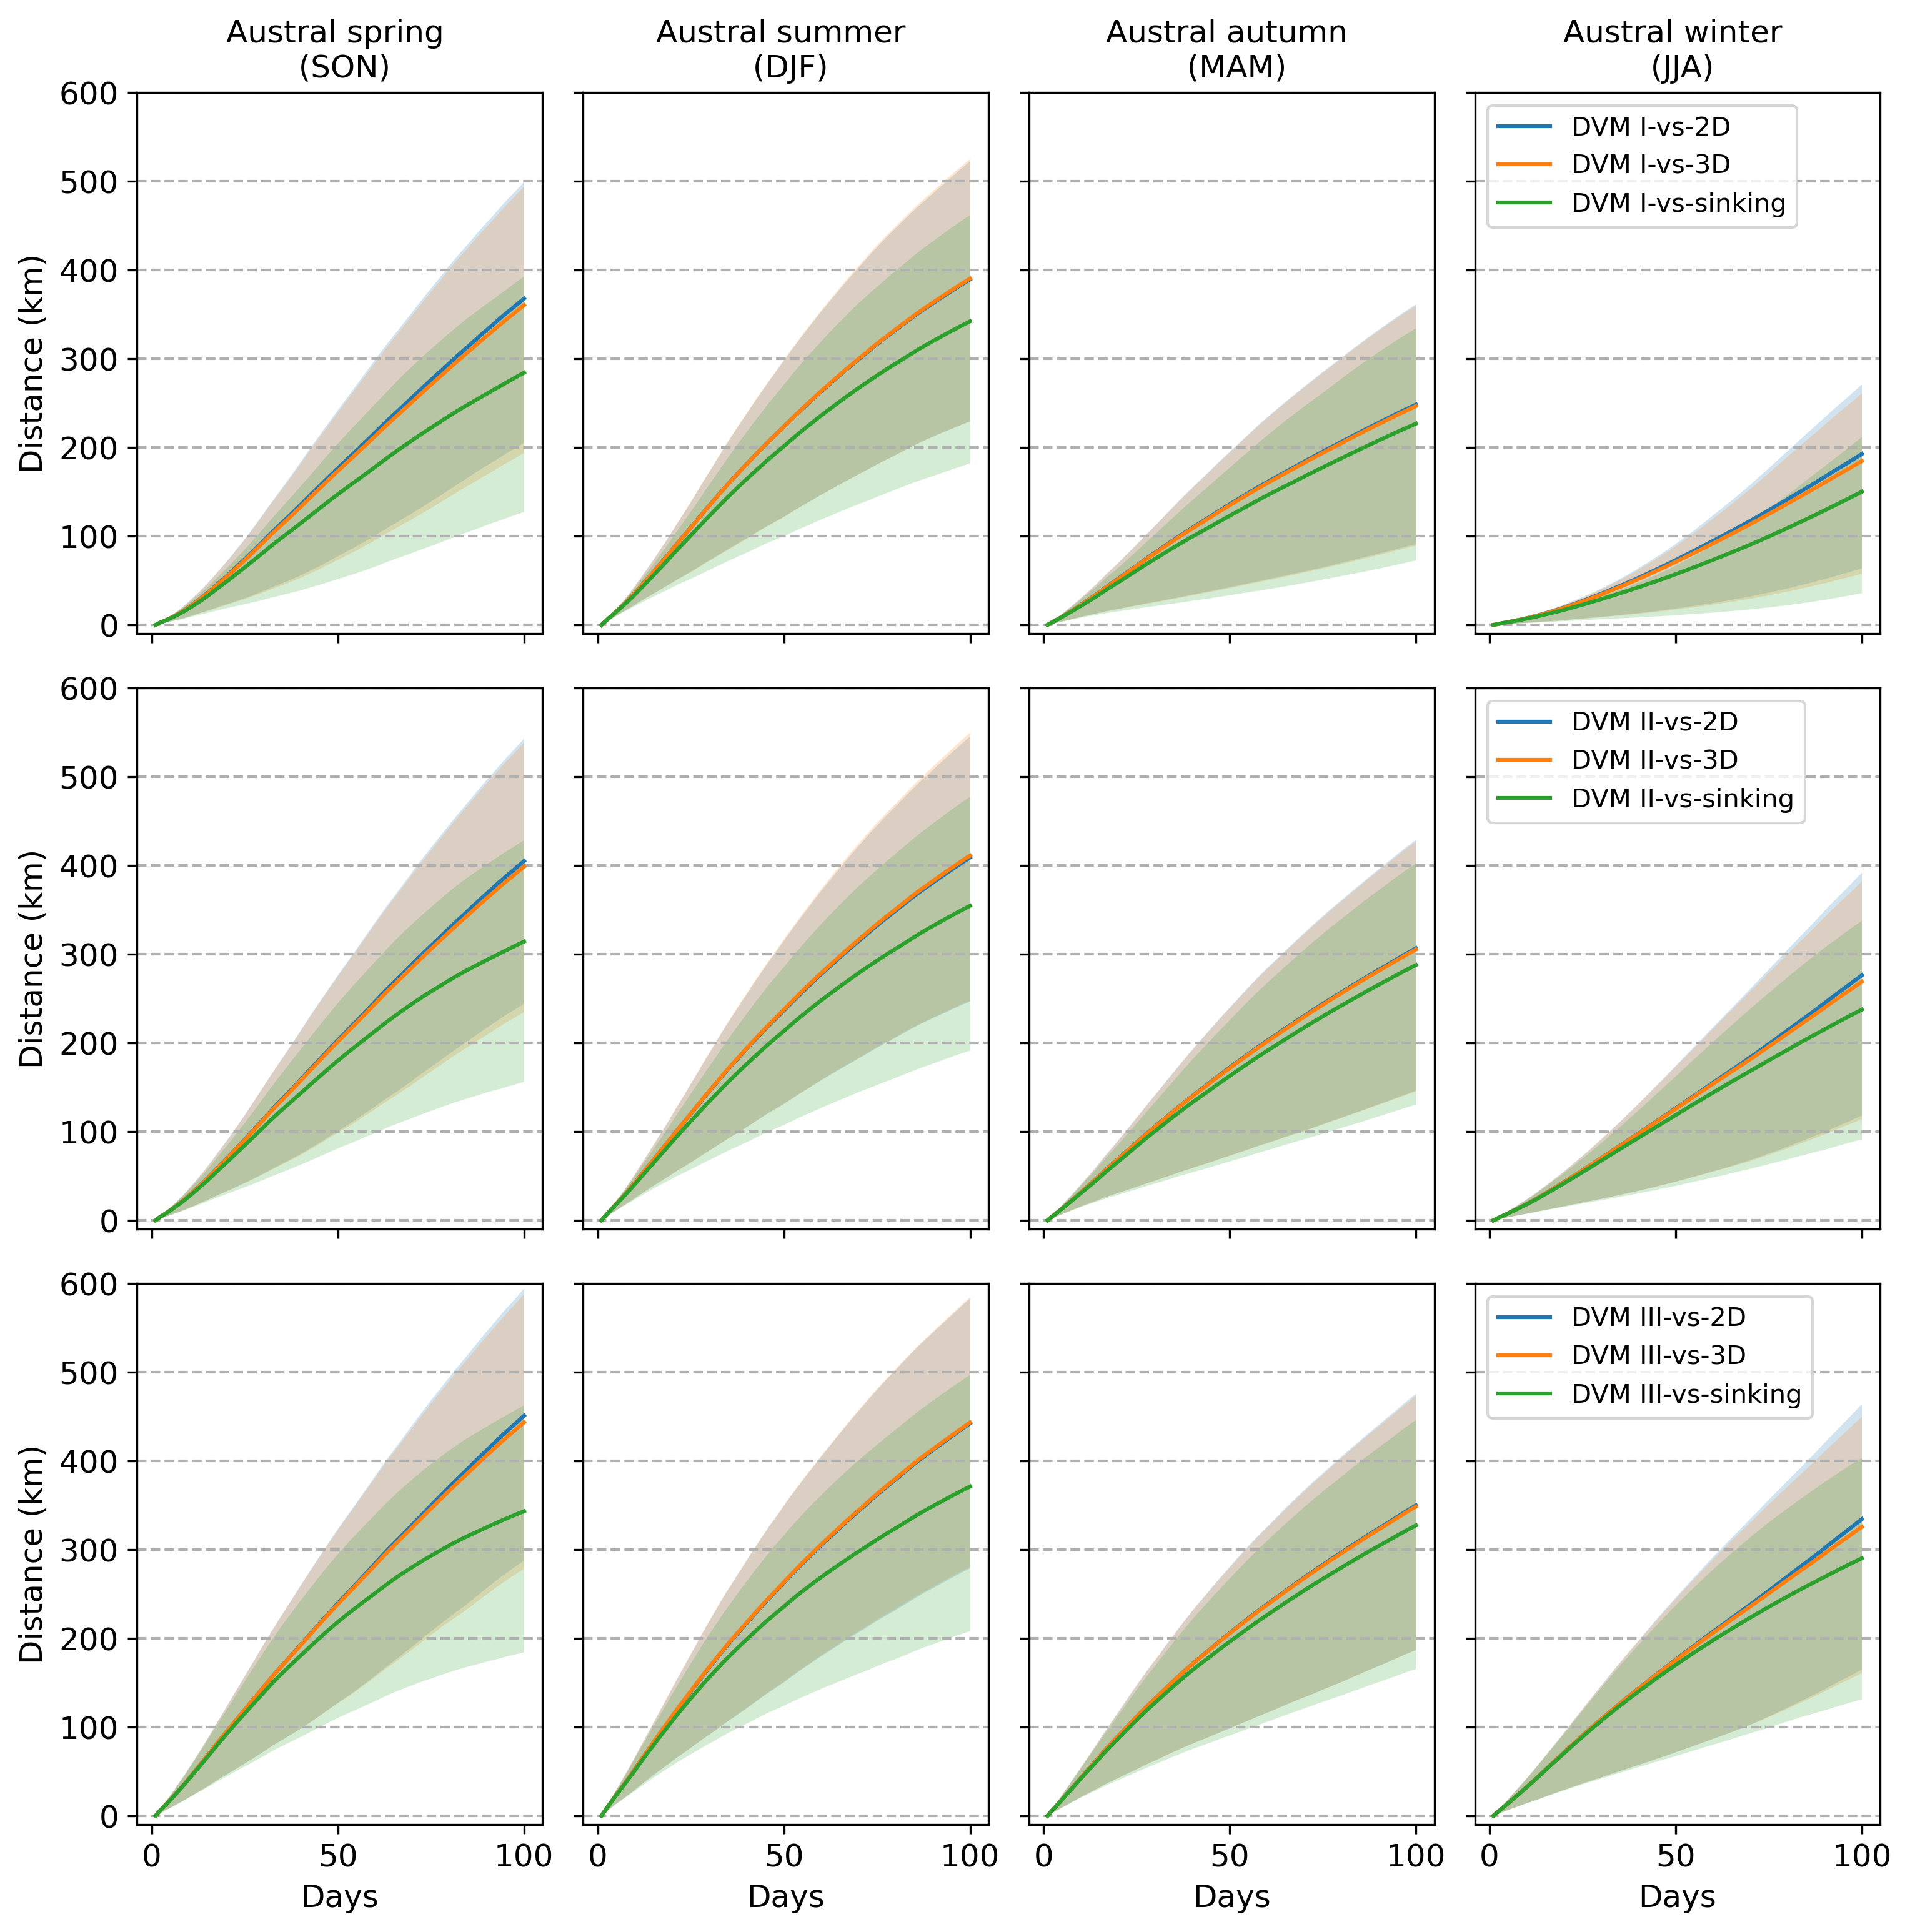

In [11]:
spring_dist = np.zeros((p_total, t_days, len(years)*3))
summer_dist = np.zeros(spring_dist.shape)
autumn_dist = np.zeros(spring_dist.shape)
winter_dist = np.zeros(spring_dist.shape)

fig, axs = plt.subplots(dpi=300,nrows=len(dvm_types), ncols=4, sharex=True, sharey=True, figsize=(12,12))
for i, dvm_mode in enumerate(dvm_types):
    for j, mode in enumerate(compare_modes):
        for index, year in enumerate(years):
            dist_data = np.load(home_folder + "outputs/Distances/{0}-{1}/all_sep_array_{0}_{1}_{2}_tc{3}km.npy".format(dvm_mode, mode, year, threshold_dist))
            spring_dist[:, :, index*3:index*3+3] = dist_data[:, :t_days, spring_ind]
            summer_dist[:, :, index*3:index*3+3] = dist_data[:, :t_days, summer_ind]
            autumn_dist[:, :, index*3:index*3+3] = dist_data[:, :t_days, autumn_ind]
            winter_dist[:, :, index*3:index*3+3] = dist_data[:, :t_days, winter_ind]
            
        plot_mean_iqr_dist(axs[i, 0], spring_dist, str(dvm_type_labels[i]+'-vs-'+mode), new_cmap(j), text_size)
        plot_mean_iqr_dist(axs[i, 1], summer_dist, str(dvm_type_labels[i]+'-vs-'+mode), new_cmap(j), text_size)
        plot_mean_iqr_dist(axs[i, 2], autumn_dist, str(dvm_type_labels[i]+'-vs-'+mode), new_cmap(j), text_size)
        plot_mean_iqr_dist(axs[i, 3], winter_dist, str(dvm_type_labels[i]+'-vs-'+mode), new_cmap(j), text_size) 

    axs[i, 0].set_ylabel("Distance (km)" , fontsize=text_size)
    axs[i, 3].legend(loc="upper left")
    

axs[0, 0].set_title("Austral spring \n (SON)", fontsize=text_size)
axs[0, 1].set_title("Austral summer \n (DJF)", fontsize=text_size)
axs[0, 2].set_title("Austral autumn \n (MAM)", fontsize=text_size)
axs[0, 3].set_title("Austral winter \n (JJA)", fontsize=text_size)
axs[2, 0].set_xlabel("Days", fontsize=text_size)
axs[2, 1].set_xlabel("Days", fontsize=text_size)
axs[2, 2].set_xlabel("Days", fontsize=text_size)
axs[2, 3].set_xlabel("Days", fontsize=text_size)

axs[0][0].set_ylim(-10,600)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.savefig(home_folder + "outputs/Figures/Seasonal_separation_distance_new_grids.pdf")

# took 11 minutes to compute for all years

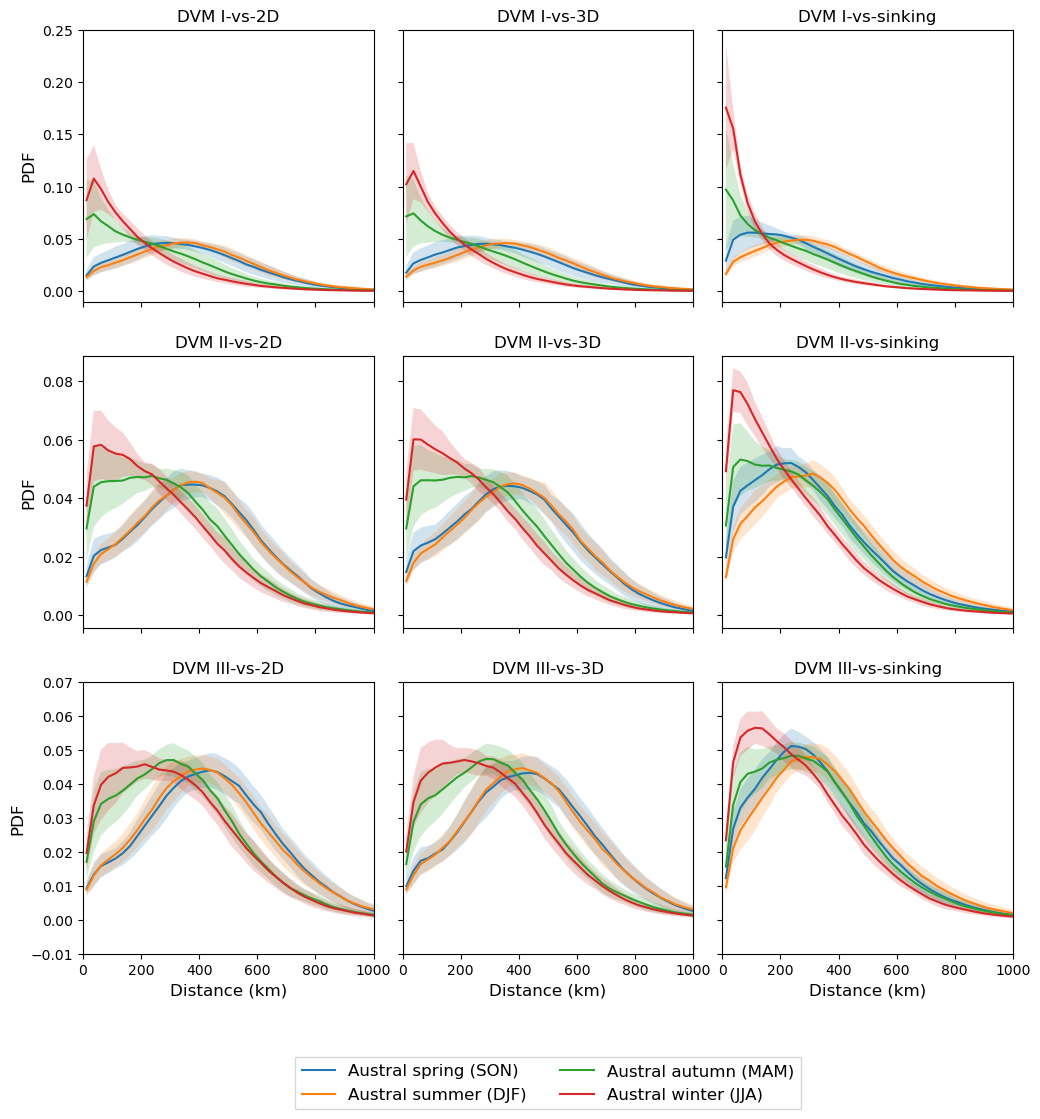

In [18]:
custom_size=12
def plot_mean_std_pdf(ax, arr, l, c):
    sigma = 1
    mean = np.nanmean(arr, axis=0)
    std = np.nanstd(arr, axis=0)
    ax.plot(bin_centers, mean, label=l, color=c)
    ax.fill_between(bin_centers, mean - sigma*std, mean + sigma*std, alpha=0.2)


spring_dist = np.zeros((len(years)*3, len(distance_bins)-1))
summer_dist = np.zeros(spring_dist.shape)
autumn_dist = np.zeros(spring_dist.shape)
winter_dist = np.zeros(spring_dist.shape)

fig, axs = plt.subplots(nrows=len(dvm_types), ncols=3, sharex=True, sharey='row', figsize=(12,12), dpi=dpi)
for i, dvm_mode in enumerate(dvm_types):
    for j,mode in enumerate(compare_modes):
        for index, year in enumerate(years):
            dist_data = np.load(home_folder+"outputs/Distances/{0}-{1}/all_sep_array_{0}_{1}_{2}_tc{3}km.npy".format(dvm_mode, mode, year, threshold_dist))
            spring_dist[index*3:index*3+3, :] = np.array([compute_distance_pdf(dist_data[:, -1, ind]) for ind in spring_ind])
            summer_dist[index*3:index*3+3, :] = np.array([compute_distance_pdf(dist_data[:, -1, ind]) for ind in summer_ind])
            autumn_dist[index*3:index*3+3, :] = np.array([compute_distance_pdf(dist_data[:, -1, ind]) for ind in autumn_ind])
            winter_dist[index*3:index*3+3, :] = np.array([compute_distance_pdf(dist_data[:, -1, ind]) for ind in winter_ind])
            
        plot_mean_std_pdf(axs[i, j], spring_dist, "Austral spring (SON)",new_cmap(0))
        plot_mean_std_pdf(axs[i, j], summer_dist, "Austral summer (DJF)",new_cmap(1))
        plot_mean_std_pdf(axs[i, j], autumn_dist, "Austral autumn (MAM)",new_cmap(2))
        plot_mean_std_pdf(axs[i, j], winter_dist, "Austral winter (JJA)",new_cmap(3)) 
        axs[i, j].set_title(str(dvm_type_labels[i]+'-vs-'+mode), fontsize=custom_size)

    axs[i, 0].set_ylabel("PDF", fontsize=custom_size)
    
axs[2, 0].set_xlabel("Distance (km)", fontsize=custom_size)
axs[2, 1].set_xlabel("Distance (km)", fontsize=custom_size)
axs[2, 2].set_xlabel("Distance (km)", fontsize=custom_size)
# axs[0, 2].legend(loc="upper right")

axs[0][0].set_ylim(-0.01, 0.25)
# axs[1][0].set_ylim(-0.01, 0.1)
axs[2][0].set_ylim(-0.01, 0.07)
axs[0][0].set_xlim(-0.01, 1000)

axs[2, 1].legend(loc='upper center', fontsize=text_size, bbox_to_anchor=(0.5, -0.35),fancybox=False, shadow=False, ncol=2)

plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig(home_folder+"outputs/Figures/PDF_final_separation_distance.pdf")
